In [1]:
import pickle as pk
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from skimage.transform import resize
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, ConfusionMatrixDisplay

In [2]:
def min_max_normal(channel, c, d):
    O = (channel.astype("float") - c) * (255 / (d - c))
    O = np.clip(O, 0, 255)
    return O.astype("uint8")


def HSV_contrast(I):
    R, G, B = cv2.split(I)

    H, S, V = cv2.split(cv2.cvtColor(I, cv2.COLOR_RGB2HSV))

    c = np.min(V)
    d = np.max(V)

    R = min_max_normal(channel=R, c=c, d=d)
    G = min_max_normal(channel=G, c=c, d=d)
    B = min_max_normal(channel=B, c=c, d=d)

    O = cv2.merge([R, G, B])
    O = cv2.cvtColor(O, cv2.COLOR_RGB2GRAY)

    return O


def contrast_stretch(I):
    kernel = np.array([[1, 1, 1], [1, -8, 1], [1, 1, 1]])
    I = HSV_contrast(cv2.cvtColor(I, cv2.COLOR_BGR2RGB))
    I = resize(I, (224, 224))

    gaus = cv2.GaussianBlur(I, (3, 3), 5.0)

    erode = cv2.erode(gaus, kernel=kernel).flatten()
    return erode


In [3]:
with open("../data/pickles/augmented.pkl", "rb") as f:
    data = pk.load(f)

row, col = 300, 300
dimension = (row, col, 1)

images, probs, types = data
y = probs

In [4]:
mask = (types == 'poly')

In [5]:
images = images[mask]
probs = probs[mask]

In [6]:
processed = []
for I in images:
    processed.append(contrast_stretch(I))

processed = np.stack(processed)


In [7]:
train_X, test_X, train_y, test_y = train_test_split(
    processed, probs, test_size=0.25, stratify=probs
)
train_X, test_X = train_X.T, test_X.T

In [8]:
def shift_mean(T):
    mu = np.mean(T, axis=1)
    Q = T - mu[:, np.newaxis]
    T_norms = np.linalg.norm(Q, np.inf, axis=1)
    T_norms[T_norms == 0] = 1
    T = Q / T_norms[:, np.newaxis]
    mu = mu.reshape((mu.shape[0], -1))
    T_norms = T_norms.reshape((T_norms.shape[0], -1))
    return T, T_norms, mu

In [9]:
train_X, train_norms, train_means = shift_mean(train_X)

In [167]:
def get_eigen(T):
    S = (1 / T.shape[1]) * (T.T @ T)
    D, C = np.linalg.eig(S)
    C = np.dot(T, C)
    C = C / np.linalg.norm(C, axis=0)
    return C, D
    

In [168]:
C, D = get_eigen(train_X)

In [176]:
def reduce_dimensionality(I, k, F, D, train_means, train_norms):
    index = D.argsort()[::-1]
    D = D[index]
    F = F[:, index]
    query = (I - train_means.reshape(-1, 1)) / train_norms.reshape(-1, 1)
    Z = F.T @ query
    Z[k:, :] = 0
    p = np.sum(D[:k]) / np.sum(D)

    return Z, p

In [177]:
def reconstruct_image(compressed_images, C, train_norms, train_means):
    A = C@compressed_images
    A = A * train_norms.reshape(-1, 1)
    A = A + train_means.reshape(-1, 1)
    return A

In [178]:
queries, p = reduce_dimensionality(test_X, 80, C, D, train_means, train_norms)
queries = reconstruct_image(queries, C, train_norms, train_means)

In [179]:
print(p)

0.9740653625993559


In [172]:
def the_nearest_image(query, train):
    query = query.reshape(query.shape[0], -1)
    norm = np.linalg.norm(query - train, axis = 0)
    index = np.argmin(norm)
    return index

In [173]:
le = LabelEncoder().fit(probs)

In [174]:
indices = []
for i in range(test_X.shape[1]):
    indices.append(the_nearest_image(queries[:, i], train_X))

In [175]:
true = []
pred = []
for i in range(test_X.shape[1]):
    true.append(test_y[i])
    pred.append(train_y[indices[i]])
    
true = np.array(true)
pred = np.array(pred)

In [155]:
true, pred = le.transform(true), le.transform(pred)

In [156]:
accuracy_score(true, pred)

0.5241635687732342

In [157]:
f1_score(true, pred, average='macro')

0.241173343340526

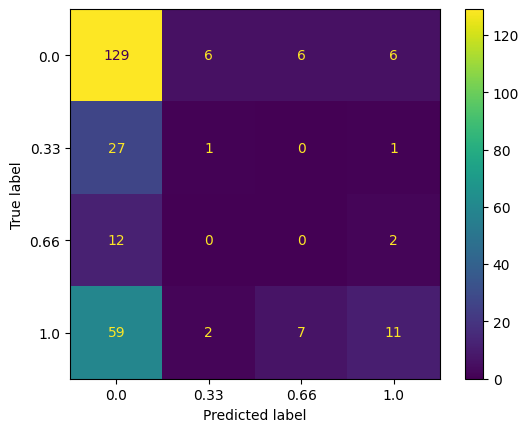

In [158]:
cm = confusion_matrix(true, pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['0.0', '0.33', '0.66', '1.0'])
disp.plot()


In [137]:
le.classes_

array([0.        , 0.33333333, 0.66666667, 1.        ])